#### Импорт необходимых объектов

In [1]:
import csv
import numpy as np
from scipy.interpolate import splrep, splev

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor


import matplotlib.pyplot as plt

#### Функция чтения набора данных

In [2]:
def get_river_dataset(fname, pr_list=None, y_name='H_max'):
    pr_arr = []
    y_arr = []
    with open(fname, newline='') as f:
        reader = csv.DictReader(f, delimiter=';')
        for row in reader:
            pr_arr_row = []
            for pr in pr_list:
                pr_arr_row.append(row[pr])

            pr_arr.append(pr_arr_row)
            y_arr.append(row[y_name])
    X = np.asarray(pr_arr, dtype=np.float64)
    y = np.asarray(y_arr, dtype=np.float64)
    return X, y

#### Сумма, средний, высший, низший уровни

In [3]:
def get_sum(h_max):
    return np.sum(h_max)
    
def get_avg(h_max):
    return np.mean(h_max)
    
def get_max(h_max):
    return np.amax(h_max)
    
def get_min(h_max):
    return np.amin(h_max)

#### Среднеквадратическая погрешность прогноза S

In [4]:
def get_s(h_max, h_forecast):
    # Среднеквадратическая погрешность прогноза
    n = h_max.shape[0]
    sqr_diff = np.sum((h_max - h_forecast) ** 2) / (n - 1)
    std = sqr_diff ** 0.5
    return std    

#### Среднеквадратическое отклонение sigma

In [5]:
def get_sigma(h_max):
    # Среднеквадратическая погрешность климатическая.
    # Рассчитывается только по всей совокупности данных.
    return np.std(h_max, ddof=1)

#### Среднее значение максимальных уровней воды

In [6]:
def get_hmax_avg(h_max):
    # Среднее значение h_max.
    # Рассчитывается только по всей совокупности данных.
    return np.mean(h_max)

#### Допустимая погрешность прогноза delta_dop

In [7]:
def get_delta_dop(sigma):
    return 0.674 * sigma

#### Критерий критерий применимости и качества методики S/sigma

In [8]:
def get_criterion(s, sigma):
    return s / sigma

#### Климатическая обеспеченность Pk

In [9]:
def get_pk(h_max, h_max_avg, delta_dop):
    diff = np.abs(h_max - h_max_avg) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Обеспеченность метода (оправдываемость) Pm

In [10]:
def get_pm(h_max, h_forecast, delta_dop):
    diff = np.abs(h_max - h_forecast) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Корреляционное отношение

In [11]:
def get_correlation_ratio(criterion):
    c_1 = (1 - criterion ** 2)
    ro = c_1 ** 0.5 if c_1 > 0 else 0
    return ro

#### Вероятная ошибка прогноза S'

In [12]:
def get_forecast_error(s):
    return 0.674 * s

#### Ошибки климатического/природного прогноза для каждого года delta50

In [13]:
def get_delta50(h_max, delta_dop, h_max_avg=None, h_max_forecast=None):
    if h_max_forecast is None:
        # delta50 климатическая
        return (h_max - h_max_avg) / delta_dop
    else:
        # delta50 прогноза
        return (h_max - h_max_forecast) / delta_dop
  

#### Функция записи в csv файл

In [14]:
import csv
def write_dataset_csv(dataset, dataset_name, fieldnames, pr_group):
    with open(
        f'results/{dataset_name}/group-{pr_group}/'
        f'{dataset_name}-гр{pr_group}.csv', 
        'w', newline='', encoding='utf-8'
    ) as csvfile:
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        writer.writeheader()
        writer.writerows(dataset)


#### Функция разделения набора данных на тренировочный и тестовый

In [15]:
def train_test_split(X, y, n_test):
    X_train = X[:-n_test]
    y_train = y[:-n_test]
    X_test = X[-n_test:]
    y_test = y[-n_test:]
    return X_train, y_train, X_test, y_test

#### Функция формирования тестового набора данных с подстановкой нормированных значений

In [16]:
def test_norm(x, pr_list, norms):
    x_norm = np.copy(x)
    for col, pr in enumerate(pr_list):
        if pr in norms:
            x_norm[:, col:col+1] = norms[pr]
    return x_norm

#### Функция получения датасетов

In [17]:
def get_datasets():
    datasets = {
        'Неман-Белица': 'Неман',
        # 'Неман-Гродно': 'Неман',
        # 'Неман-Мосты': 'Неман',
        # 'Неман-Столбцы': 'Неман',
    }
    return datasets

#### Функция получения списка предикторов по названию датасета

In [18]:
def get_predictors(dataset_name, pr_group):

    datasets = get_datasets()   
    predictors_lists = {
        'Неман': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'],
        )
    }
    return predictors_lists[datasets[dataset_name]][pr_group]
    

#### Функция получения нормированных значений предикторов

In [19]:
def get_norms(dataset_name):
    norms_list = {
        'Неман-Белица': {'X1': 46.0, 'X2':35.0},
        'Неман-Гродно': {'X1': 36.0, 'X2':26.0},
        'Неман-Мосты': {'X1': 40.0, 'X2':31.0},
        'Неман-Столбцы': {'X1': 43.0, 'X2':34.0},
    }
    return norms_list[dataset_name]

    

#### Функция получения аугментированных данных

In [20]:
def augment_data(x_data, y_data, n, k=1):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=k)
        x_points_n = np.linspace(0, data_len, n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T
    #print(x_augmented)

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=k)
    y_points_n = np.linspace(0, data_len, n)
    y_augmented = splev(y_points_n, y_spl)
    #print(y_augmented)

    plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    plt.show()
    
    return x_augmented, y_augmented

#### Функция обучения и оценки моделей

In [21]:
def compare_models(pr_group, n_test=None, norms=True, top_best=None, augment=0):
    
    ds_dir = 'data'
    
    names = [
        'LinearRegression',
        'Ridge',
        'Lasso',
        'ElasticNet',
        'Lars1',
        'Lars2',
        'Lars3',
        'Lars4',
        'Lars5',
        'LassoLars',
        'OMP1',
        'OMP2',
        'OMP3',
        'OMP4',
        'OMP5',
        'BayesianRidge',
        'ARDRegression',
        'SGDRegressor', 
        'PassiveAggressiveRegressor',
        'HuberRegressor',
        'TheilSenRegressor',
        'QuantileRegressor',               
    ]

    # Инициализация генератора случайных чисел для
    # для обеспечения воспроизводимости результатов
    rng = np.random.RandomState(0)

    # Наборы гиперпараметров моделей для алгоритма кроссвалидации
    # Гиперпараметры для Ridge, Lasso, ElasticNet, LassoLars, HuberRegressor
    alphas = np.logspace(-4, 3, num=100)
    
    # Гиперпараметры для ElasticNet
    l1_ratio = np.linspace(0.01, 1.0, num=50)
    
    # Гиперпараметры для BayesianRidge
    alphas_init = np.linspace(0.5, 2, 5)
    lambdas_init = np.logspace(-3, 1, num=5)
    
    # Гиперпараметры для ARDRegression
    alphas_lambdas = np.logspace(-7, -4, num=4)
    
    # Гиперпараметры для SGDRegressor
    losses = ['squared_error', 'huber', 
              'epsilon_insensitive', 'squared_epsilon_insensitive']
    sgd_alphas = np.logspace(-4, 1, num=100)
   
    # Гиперпараметры для PassiveAggressiveRegressor
    cc = np.linspace(0.1, 1.5, 50)
    
    # Гиперпараметры для HuberRegressor
    epsilons = np.append(np.linspace(1.1, 2.0, 10), [1.35])
    
    # Гиперпараметры для TheilSenRegressor
    n_subsamples = np.arange(6, 24)
    
    # Гиперпараметры для QuantileRegressor
    q_alphas = np.linspace(0, 2, 20)    
           
    
    regressors = [
        LinearRegression(),
        
        GridSearchCV(
            estimator=Ridge(random_state=rng), 
            param_grid={"alpha": alphas}
        ),
        
        GridSearchCV(
            estimator=Lasso(random_state=rng), 
            param_grid={"alpha": alphas}
        ),
        
        GridSearchCV(
            estimator=ElasticNet(random_state=rng), 
            param_grid={"alpha": alphas, "l1_ratio": l1_ratio}, 
            n_jobs=-1
        ),
        
        Lars(n_nonzero_coefs=1),
        Lars(n_nonzero_coefs=2),
        Lars(n_nonzero_coefs=3),
        Lars(n_nonzero_coefs=4),
        Lars(n_nonzero_coefs=5),
        
        GridSearchCV(
            estimator=LassoLars(random_state=rng), 
            param_grid={"alpha": alphas}
        ),
        
        OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        OrthogonalMatchingPursuit(n_nonzero_coefs=2),
        OrthogonalMatchingPursuit(n_nonzero_coefs=3),
        OrthogonalMatchingPursuit(n_nonzero_coefs=4),
        OrthogonalMatchingPursuit(n_nonzero_coefs=5),
        
        GridSearchCV(
            estimator=BayesianRidge(),
            param_grid={"alpha_init": alphas_init, "lambda_init": lambdas_init}, 
            n_jobs=-1
        ),
        
        GridSearchCV(
            estimator=ARDRegression(), 
            param_grid={"alpha_1": alphas_lambdas, "alpha_2": alphas_lambdas,
                        "lambda_1": alphas_lambdas,"lambda_2": alphas_lambdas}, 
            n_jobs=-1
        ),
        
        GridSearchCV(
            estimator=SGDRegressor(random_state=rng), 
            param_grid={"loss": losses, "alpha": sgd_alphas}, 
            n_jobs=-1
        ),
        
        GridSearchCV(
            estimator=PassiveAggressiveRegressor(random_state=rng), 
            param_grid={"C": cc}, 
            n_jobs=-1, 
            cv=3
        ),
        
        GridSearchCV(
            estimator=HuberRegressor(), 
            param_grid={"epsilon": epsilons, "alpha": alphas}, 
            n_jobs=-1 
        ),
        
        GridSearchCV(
            estimator=TheilSenRegressor(random_state=rng), 
            param_grid={"n_subsamples": n_subsamples}, 
            n_jobs=-1
        ),
        
        GridSearchCV(
            estimator=QuantileRegressor(), 
            param_grid={"alpha": q_alphas}, 
            n_jobs=-1
        ),
    ]

    datasets = get_datasets()

    fieldnames = [
        'Predictors', 
        'Equations', 
        'Method', 
        'Criterion', 
        'Correlation', 
        'Pm'
    ]

    # Описание структуры данных переменной datasets_result
    # datasets_result = {
    #     "hydropost_0": [
    #         { model_row }
    #         { model_row }
    #     ],
    #     ...,
    #     "hydropost_n": [
    #         { model_row }
    #         { model_row }
    #     ],
    # }
    
    
    # Итерация по датасетам
    datasets_result = dict()
    for ds in datasets:
        result_list = []
        
        pr_list = get_predictors(ds, pr_group)
        
        X, y = get_river_dataset(f'{ds_dir}/{ds}.csv', pr_list=pr_list)

        if augment:
           X_aug, y_aug = augment_data(X, y, augment)
  

        if n_test is not None and n_test != 0:
            X_train, y_train, X_test, y_test = train_test_split(X, y, n_test)
        else:
            if augment:
                X_train = X_aug[:]
                y_train = y_aug[:]
                X_test = X[:]
                y_test = y[:]
            else:
                X_train = X[:]
                y_train = y[:]
                X_test = X_train
                y_test = y_train

        if norms:
            norms = get_norms(ds)
            X_test = test_norm(X_test, pr_list, norms)
            
        # Итерация по моделям регрессии
        for name, regr in zip(names, regressors):
            one_model_row = dict()

            regr.fit(X_train, y_train)
                
            y_predicted = np.ravel(regr.predict(X_test))           

            try:
                coef = regr.best_estimator_.coef_
                intercept = regr.best_estimator_.intercept_
                
                if isinstance(intercept, np.ndarray):
                    intercept = intercept[0]
            except Exception as error:
                
                coef = regr.coef_
                intercept = regr.intercept_
                
                if isinstance(intercept, np.ndarray):
                    intercept = intercept[0]
                print(error)
                
            # Коэффициенты уравнения (если есть)
            coef = np.around(np.ravel(coef), 3)
            intercept = round(intercept, 3)
            try:
                predictors_coef = {f: c for f, c 
                                   in zip(pr_list, coef) if c != 0.0}
                
                predictors = ", ".join(predictors_coef.keys())
                
                equation = (
                    str(intercept) 
                    + ' ' 
                    + ' '.join(str(c) + '*' 
                               + f for f, c in predictors_coef.items())
                )
                
                equation = equation.replace(" -", "-")
                equation = equation.replace(" ", " + ")
                equation = equation.replace("-", " - ")
    
                one_model_row['Predictors'] = predictors
                one_model_row['Equations'] = equation
            except Exception as error:
                print(error)
                one_model_row['Predictors'] = ""
                one_model_row['Equations'] = ""

            # Название датасета
            one_model_row['Dataset_name'] = ds

            # Группа предикторов
            one_model_row['Group'] = pr_group
                
            # Название метода
            one_model_row['Method'] = name

            # Расчет показателей качества по методике

            # Сумма, максимум, минимум максимальных уровней
            one_model_row['H_sum'] = get_sum(y)
            one_model_row['H_max'] = get_max(y)
            one_model_row['H_min'] = get_min(y)
            
            # Среднее значение максимального уровня по всей выборке
            h_max_avg = get_hmax_avg(y)
            one_model_row['H_avg'] = h_max_avg
            
            # Среднеквадратическое отклонение
            sigma = get_sigma(y)
            one_model_row['Sigma'] = sigma

            # Допустимая погрешность прогноза
            delta_dop = get_delta_dop(sigma)
            one_model_row['Delta_dop'] = delta_dop

            # Обеспеченность климатическая Pk
            pk = get_pk(y_test, h_max_avg, delta_dop)
            one_model_row['Pk'] = pk

            # Обеспеченность метода (оправдываемость) Pm
            pm = get_pm(y_test, y_predicted, delta_dop)
            one_model_row['Pm'] = pm

            # Среднеквадратическая погрешность прогноза
            s_forecast = get_s(y_test, y_predicted)
            one_model_row['S'] = s_forecast
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma
            criterion_forecast = get_criterion(s_forecast, sigma)
            one_model_row['Criterion'] = criterion_forecast

            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma в квадрате
            criterion_sqr = get_criterion(s_forecast, sigma) ** 2.0
            one_model_row['Criterion_sqr'] = criterion_sqr
            
            # Корреляционное отношение ro
            correlation_forecast = get_correlation_ratio(criterion_forecast)
            one_model_row['Correlation'] = correlation_forecast
                        
            # Обученная модель
            one_model_row['Model'] = regr

            # Добавление результатов модели в результирующий список по датасету
            result_list.append(one_model_row)

        # Сортировка результатов по каждому датасету
        result_list.sort(
            key=lambda row: (row['Criterion'], 
                             -row['Correlation'], 
                             -row['Pm'])
        )

        datasets_result[ds] = result_list

        # Запись в .csv файл
        write_dataset_csv(result_list, ds, fieldnames, pr_group=pr_group)

        for i, rl in enumerate(result_list):
            if top_best is not None:
                if i >= top_best:
                    break
            verify_forecast(ds, rl, i, pr_group=pr_group, n_test=n_test)

    return datasets_result

#### Функция формирования проверочных прогнозов

In [22]:
def verify_forecast(dataset_name, rl, num, pr_group, n_test=None, norms=True):

    ds_dir = 'data'

    pr_list = get_predictors(dataset_name, pr_group)
    pr_list = ['year'] + pr_list
    
    fieldnames = [
        '№', 
        'Год',
        'Hmax фактический', 
        'Hф-Hср', 
        '(Hф-Hср)^2', 
        
        'δ50% Погрешность климатических прогнозов '
        'в долях от допустимой погрешности',
        
        'Hmax прогнозный', 
        'Hф-Hп', 
        '(Hф-Hп)^2', 
        
        'δ50% Погрешность проверочных прогнозов '
        'в долях от допустимой погрешности',
    ]

    X, y = get_river_dataset(
        f'{ds_dir}/{dataset_name}.csv', pr_list=pr_list, y_name='H_max'
    )

    if n_test is not None and n_test != 0:
        _, _, X_test, y_test = train_test_split(X, y, n_test)
    else:
        X_test = X
        y_test = y

    if norms:
        norms = get_norms(dataset_name)
        X_test = test_norm(X_test, pr_list, norms)

    # Выделение первой колонки (года) из набора предикторов
    years = X_test[:, 0]
    X_test = X_test[:, 1:]
    
    # Forecast
    h_max_forecast = np.ravel(rl['Model'].predict(X_test))
    
    # Hсредний
    h_max_avg = np.mean(y)

    # H - Hсредний
    diff_fact = y_test - h_max_avg

    # (H - Hсредний) в квадрате
    diff_fact_sqr = diff_fact ** 2

    # Погрешность климатических прогнозов в долях от допустимой погрешности
    delta_dop = get_delta_dop(get_sigma(y))
    error_climate = get_delta50(y_test, delta_dop, h_max_avg=h_max_avg)

    # H - Hпрогнозный
    diff_forecast = y_test - h_max_forecast

    # (H - Hпрогнозный) в квадрате
    diff_forecast_sqr = diff_forecast ** 2       

    # Погрешность проверочных прогнозов в долях от допустимой погрешности
    error_forecast = get_delta50(
        y_test, delta_dop, h_max_forecast=h_max_forecast
    )

    # Номер по порядку
    rows_num = y_test.shape[0]
    npp = np.arange(1, rows_num + 1, 1)

    # Конкатенация массивов
    att_tuple = (
        npp, 
        years, 
        y_test, 
        diff_fact, 
        diff_fact_sqr, 
        error_climate, 
        h_max_forecast, 
        diff_forecast, 
        diff_forecast_sqr, 
        error_forecast
    )
    
    arr = np.column_stack(att_tuple)
    arr = arr.tolist()

    # Обеспеченность метода (оправдываемость) Pm
    pm = get_pm(y_test, h_max_forecast, delta_dop)
    
    # Запись проверочного прогноза в csv файл
    with open(
        f'results/{dataset_name}/group-{pr_group}/{dataset_name}'
        f'-проверочный-гр{pr_group}-{num:0>2}.csv', 
        'w', 
        newline='', 
        encoding='utf-8'
    ) as csvfile:
        
        stat_header = (
            f"Таблица  - "
            f"Проверочные прогнозы максимумов весеннего половодья\n"
            f"р.{rl['Dataset_name']}\n"
            f"Предикторы:;; {rl['Predictors']}\n"
            f"Уравнение:;; {rl['Equations']}\n"
            f"Модель:;; {rl['Method']}\n\n"
        )
        
        csvfile.write(stat_header)
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(fieldnames)
        writer.writerows(arr)
        
        stat_footer = (
            f"Сумма;;{rl['H_sum']}\n"  
            f"Средний;;{rl['H_avg']}\n" 
            f"Высший;;{rl['H_max']}\n"
            f"Низший;;{rl['H_min']}\n\n"
            
            f"σ = ;;{rl['Sigma']};;σ -;"
            f"среднеквадратическое отклонение (см)\n" 
            
            f"δдоп =;;{rl['Delta_dop']};;δдоп -;"
            f"допустимая погрешность прогноза (см)\n" 
            
            f"Pк =;;{rl['Pk']};;Pк -;"
            f"климатическая обеспеченность в %\n"
            
            f"Pм =;;{rl['Pm']};;Pм -;"
            f"обеспеченность метода в %\n"
            
            f"S =;;{rl['S']};;;"
            f"(допустимой погрешности проверочных прогнозов)\n"
            
            f"S/σ =;;{rl['Criterion']};;S -;"
            f"среднеквадратическая погрешность (см)\n" 
            
            f"(S/σ)^2 =;;{rl['Criterion_sqr']};;S/σ -;"
            f"критерий эффективности метода прогнозирования\n"
            
            f"ρ =;;{rl['Correlation']};;ρ -;"
            f"корреляционное отношение\n"
            
            f";;;;;(оценка эффективности метода прогнозирования)\n"
            f";;;;δ50% -;погрешность (ошибка) прогнозов (см)\n"
        )
        
        csvfile.write(stat_footer) 

#### Запуск процесса обучения моделей, формирования наборов уравнений множественной регрессии и проверочных прогнозов

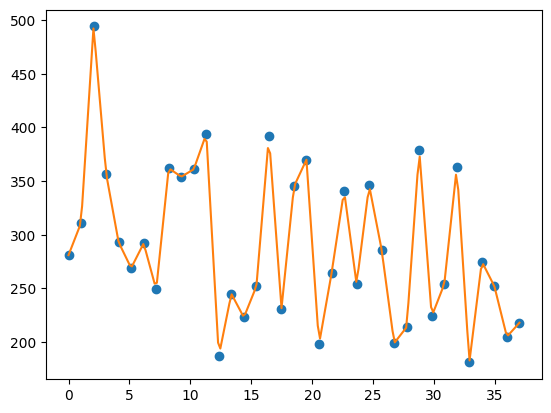

'LinearRegression' object has no attribute 'best_estimator_'
'Lars' object has no attribute 'best_estimator_'
'Lars' object has no attribute 'best_estimator_'
'Lars' object has no attribute 'best_estimator_'
'Lars' object has no attribute 'best_estimator_'
'Lars' object has no attribute 'best_estimator_'
'OrthogonalMatchingPursuit' object has no attribute 'best_estimator_'
'OrthogonalMatchingPursuit' object has no attribute 'best_estimator_'
'OrthogonalMatchingPursuit' object has no attribute 'best_estimator_'
'OrthogonalMatchingPursuit' object has no attribute 'best_estimator_'
'OrthogonalMatchingPursuit' object has no attribute 'best_estimator_'


F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


In [23]:
top_best = None
result1 = compare_models(pr_group=1, n_test=0, norms=True, top_best=top_best, augment=200)          
#result2 = compare_models(pr_group=2, n_test=0, norms=True, top_best=top_best)

In [24]:
a = [1,3,5,7]
b = [2,4,6,8]
c = []
c.append(a)
c.append(b)
print(c)
arr = np.asarray(c)
print(arr)

[[1, 3, 5, 7], [2, 4, 6, 8]]
[[1 3 5 7]
 [2 4 6 8]]
